In [3]:
image_dir = Path('../input/boat-types-recognition')

In [4]:
image_files = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], image_files))
image_df = pd.DataFrame({'Filepath': image_files, 'Label': labels}).astype(str).sample(frac=1.0, random_state=1).reset_index(drop=True)
image_df

,Filepath,Label
0,../input/boat-types-recognition/gondola/venice...,gondola
1,../input/boat-types-recognition/kayak/canoe-wa...,kayak
2,../input/boat-types-recognition/paper boat/shi...,paper boat
3,../input/boat-types-recognition/kayak/lake-isl...,kayak
4,../input/boat-types-recognition/gondola/venice...,gondola
...,...,...
2919,../input/boat-types-recognition/sailboat/natur...,sailboat
2920,../input/boat-types-recognition/kayak/action-a...,kayak
2921,../input/boat-types-recognition/boats/gondola/...,gondola
2922,../input/boat-types-recognition/gondola/gondol...,gondola


In [5]:
image_df['Label'].value_counts()

sailboat           976
kayak              508
gondola            484
cruise ship        478
ferry boat         162
buoy               136
paper boat          80
freight boat        58
inflatable boat     42
Name: Label, dtype: int64

In [6]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


In [8]:
train_images = train_generator.flow_from_dataframe(dataframe=train_df,x_col='Filepath', y_col='Label',target_size=(224, 224),
                                                   color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, 
                                                   subset='training')

val_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='Filepath', y_col='Label', target_size=(224, 224),
                                                 color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True,
                                                 seed=42, subset='validation')

test_images = test_generator.flow_from_dataframe(dataframe=test_df, x_col='Filepath', y_col='Label',
                                                 target_size=(224, 224), color_mode='rgb', class_mode='categorical',
                                                 batch_size=32, shuffle=False)

Found 1637 validated image filenames belonging to 9 classes.
Found 409 validated image filenames belonging to 9 classes.
Found 878 validated image filenames belonging to 9 classes.


In [9]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(train_images,validation_data=val_images,
                    epochs=100,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)])


Epoch 1/100
52/52 [==============================] - 62s 1s/step - loss: 1.9626 - accuracy: 0.3347 - val_loss: 1.8002 - val_accuracy: 0.3276
Epoch 2/100
52/52 [==============================] - 40s 769ms/step - loss: 1.7853 - accuracy: 0.3618 - val_loss: 1.7783 - val_accuracy: 0.3276
Epoch 3/100
52/52 [==============================] - 39s 750ms/step - loss: 1.7890 - accuracy: 0.3454 - val_loss: 1.7385 - val_accuracy: 0.3276
Epoch 4/100
52/52 [==============================] - 39s 753ms/step - loss: 1.7403 - accuracy: 0.3310 - val_loss: 1.7145 - val_accuracy: 0.3276
Epoch 5/100
52/52 [==============================] - 40s 768ms/step - loss: 1.6876 - accuracy: 0.3642 - val_loss: 1.6925 - val_accuracy: 0.3765
Epoch 6/100
52/52 [==============================] - 38s 736ms/step - loss: 1.6667 - accuracy: 0.3998 - val_loss: 1.6673 - val_accuracy: 0.3912
Epoch 7/100
52/52 [==============================] - 40s 765ms/step - loss: 1.6839 - accuracy: 0.3856 - val_loss: 1.6648 - val_accuracy: 0.

In [10]:
results = model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.37703
Test Accuracy: 56.04%


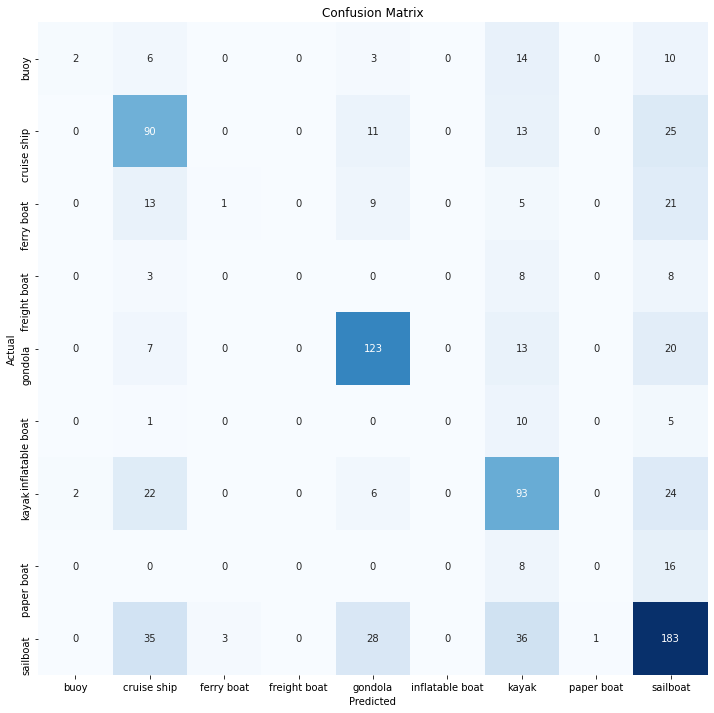

Classification Report:
----------------------
                  precision    recall  f1-score   support

           buoy       0.50      0.06      0.10        35
    cruise ship       0.51      0.65      0.57       139
     ferry boat       0.25      0.02      0.04        49
   freight boat       0.00      0.00      0.00        19
        gondola       0.68      0.75      0.72       163
inflatable boat       0.00      0.00      0.00        16
          kayak       0.47      0.63      0.54       147
     paper boat       0.00      0.00      0.00        24
       sailboat       0.59      0.64      0.61       286

       accuracy                           0.56       878
      macro avg       0.33      0.31      0.29       878
   weighted avg       0.51      0.56      0.52       878



In [14]:
predictions = np.argmax(model.predict(test_images), axis=1)
cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=list(train_images.class_indices.keys()))
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(9) + 0.5, labels=list(train_images.class_indices.keys()))
plt.yticks(ticks=np.arange(9) + 0.5, labels=list(train_images.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print("Classification Report:\n----------------------\n", clr)
